# Setup the enviroment

In [1]:

import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
from sklearn import metrics
import lightgbm
warnings.simplefilter('ignore')
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error


# Read the data

In [2]:
print(os.path.exists("rgr_preprocessed.csv"))

True


In [3]:
df = pd.read_csv("rgr_preprocessed.csv")
df_original = pd.read_csv("Mobile Price Prediction Datatset.csv")

In [4]:
df['Price'].value_counts()

Price
0.000297    32
0.000559    19
0.001258    19
0.001083    17
0.001432    15
            ..
0.011738     1
0.000823     1
0.441069     1
0.016607     1
0.036715     1
Name: count, Length: 253, dtype: int64

In [5]:
df_original['Price'].value_counts()

Price
649       32
799       19
1199      19
1099      17
1299      15
          ..
7199       1
950        1
253000     1
9987       1
21499      1
Name: count, Length: 253, dtype: int64

# Modelling

### Define feature and target columns

In [6]:
X = df.drop(['Price', 'Unnamed: 0'], axis=1)
Y = df['Price']

### Data splitting
We'll split the data into 80:10:10 portions with train, validation and test sets respectivly.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_rem, Y_train, Y_rem = train_test_split(X, Y, train_size=0.8,  random_state=0)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem, Y_rem, test_size=0.5,  random_state=0)

Let's check the distribution of classes in sets:

'Stratify' parameter for function 'train_test_split' worked well dealing with splitting data with proportional amounts of target categories.

### Models

In [8]:
models = {
    'Linear Regression': LinearRegression(),
    'Support Vector Regressor (SVR)': SVR(),
    'Random Forest': RandomForestRegressor(verbose=0),
    'Gradient Boosting': GradientBoostingRegressor(verbose=0),
    'XGBoost': XGBRegressor(verbosity=0)
}

In [9]:
# create a function to fit, predict and evaluate models
def fit_predict_score(model, X_train, Y_train, X_valid, Y_valid):
    model.fit(X_train, Y_train)
    Y_pred = np.round(model.predict(X_valid.values))
    return metrics.accuracy_score(Y_valid, Y_pred), metrics.f1_score(Y_valid, Y_pred, average='weighted')

In [10]:
def evaluate_models(models, X_train, y_train, X_valid, y_valid):
    results = {'Model': [], 'MAE': [], 'MSE': [], 'MAPE': []}
    for model_name, model in models.items():
        print(f'Evaluating {model_name}...')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        mae = mean_absolute_error(y_valid, y_pred)
        mse = mean_squared_error(y_valid, y_pred)
        mape = mean_absolute_percentage_error(y_valid, y_pred)
        results['Model'].append(model_name)
        results['MAE'].append(mae)
        results['MSE'].append(mse)
        results['MAPE'].append(mape)
    return pd.DataFrame(results)

In [11]:
# evaluate models
results = evaluate_models(models, X_train, Y_train, X_valid, Y_valid)

Evaluating Linear Regression...
Evaluating Support Vector Regressor (SVR)...
Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating XGBoost...


In [12]:
results.sort_values('MAPE', ascending=False)

,Model,MAE,MSE,MAPE
1,Support Vector Regressor (SVR),0.048569,0.003266,37.734706
0,Linear Regression,0.029877,0.001968,29.546744
2,Random Forest,0.012169,0.001822,16.192015
3,Gradient Boosting,0.011643,0.002148,15.659554
4,XGBoost,0.006915,0.000764,3.923715


# Feature importance
Let's see which features had the biggest impact on results of modeling:

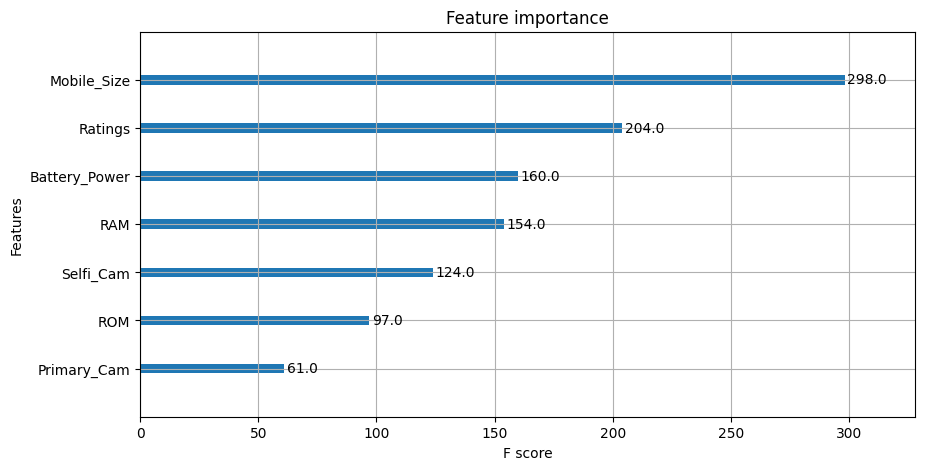

In [13]:
from xgboost import plot_importance

plt.rcParams["figure.figsize"] = (10, 5)
plot_importance(models['XGBoost'], max_num_features=20)
plt.show()